In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -qq transformers accelerate mlx_lm ipywidgets 
!pip install -U -qq bitsandbytes

In [3]:
import csv 

from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np

import os.path as osp 

import pandas as pd
from pprint import pprint

import re

import sys
sys.path.append("../")

from tqdm.auto import tqdm
import torch
import torch.nn as nn

from typing import Tuple, Any

In [4]:
from src.__init__ import logger
from src.config import Config
from src.model import ARCModel
from src.utils import (load_data, 
                        sample_arc_task, 
                        visualize_task, 
                        infer_out_shape,
                        get_row_sizes,
                        reconstruct_grids,
                        generate_submission,
                        get_grid_shape)

In [5]:
train_data, test_data = load_data(data_path=Config.data_path)

print(f"✓ Loaded {len(train_data)} training problems")

✓ Loaded 746 training problems


In [6]:
base_prompt_path = "./src/base_prompt.txt"

with open(base_prompt_path, "r") as f:
    base_prompt = f.read().strip()
    
model = ARCModel(
    system_prompt_path=base_prompt_path, 
    verbose=False,
    base_llm_name=None
)

# Try out Model

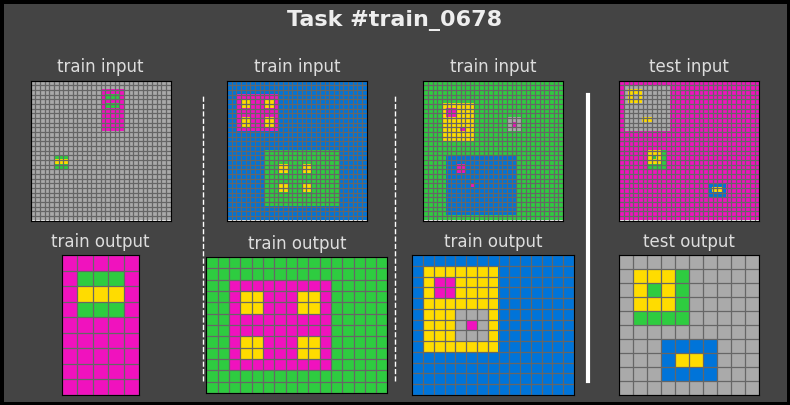

In [7]:
task_id, task = sample_arc_task(train_data, split=None)

test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9
)

In [8]:
%%time 

expected_shape = get_grid_shape(test_output)

out = model.solve(
    task=task, 
    expected_rows=expected_shape[0],
    verbose=True
)

out

[INFO] Test input shape matches a training input shape exactly
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(10, 5)
[INFO] final_shape=(10, 5)
[INFO] Done!
CPU times: user 3 ms, sys: 1.99 ms, total: 5 ms
Wall time: 3.14 ms


[[6, 6, 6, 6, 6],
 [6, 5, 5, 5, 5],
 [6, 5, 4, 4, 4],
 [6, 5, 4, 5, 4],
 [6, 5, 4, 4, 4],
 [6, 5, 5, 5, 5],
 [6, 5, 5, 5, 5],
 [6, 5, 5, 5, 5],
 [6, 5, 5, 5, 5],
 [6, 5, 5, 5, 5]]

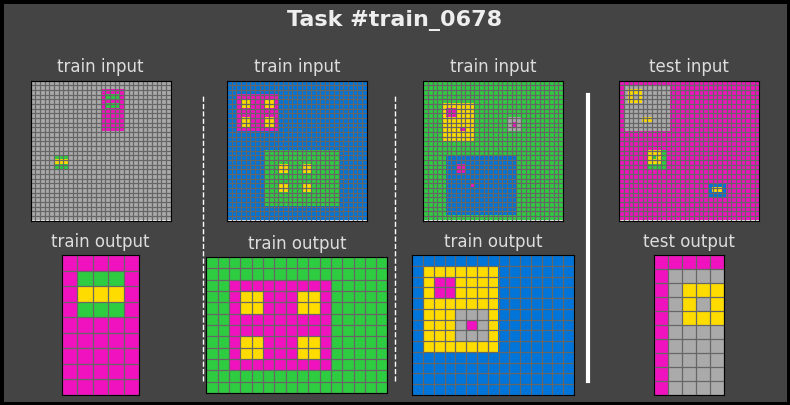

In [9]:
solution = {
    f"{task_id}": out
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

# Batch Solving

In [10]:
total_match = 0
total_pix_acc = 0
train_preds = []
N = 10

expected_shape = None

for _ in range(N):
    task_id, task = sample_arc_task(train_data, split=None)    
    logger.info(f"{task_id=}")
    
    test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

    if test_output is not None:
        expected_shape = get_grid_shape(test_output)
    
    pred = model.solve(
        task=task, 
        expected_rows=expected_shape[0] if expected_shape else None,
        verbose=True
    )

    solution = {
        f"{task_id}": pred
    }
    
    train_preds.append(solution)

    metrics = model.evaluate(task, [pred])
    match, pix_acc = metrics.values()
        
    total_match+=match
    total_pix_acc+=pix_acc

    print()

avg_acc = total_match/N
avg_pix_acc = total_pix_acc/N

print(f"{avg_acc*100:.5f}% correct matches with {avg_pix_acc*100:.5f}% pixel acc")

[INFO] task_id='train_0743'
[INFO] Input and output shapes are identical in all pairs
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(15, 15)
[INFO] final_shape=(15, 15)
[INFO] Done!

[INFO] task_id='train_0194'
[INFO] Looking for constant scaling between input and output
[INFO] Inconsistency detected...exploring other options.
[INFO] Use test input shape with expected_rows override
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(7, 19)
[INFO] final_shape=(7, 19)
[INFO] Done!

[INFO] task_id='train_0589'
[INFO] Input and output shapes are identical in all pairs
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(4, 4)
[INFO] final_shape=(4, 4)
[INFO] Done!

[INFO] task_id='train_0327'
[INFO] Looking for constant scaling between input and output
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(17, 5)
[INFO] final_shape=(17, 5)
[INFO] Done

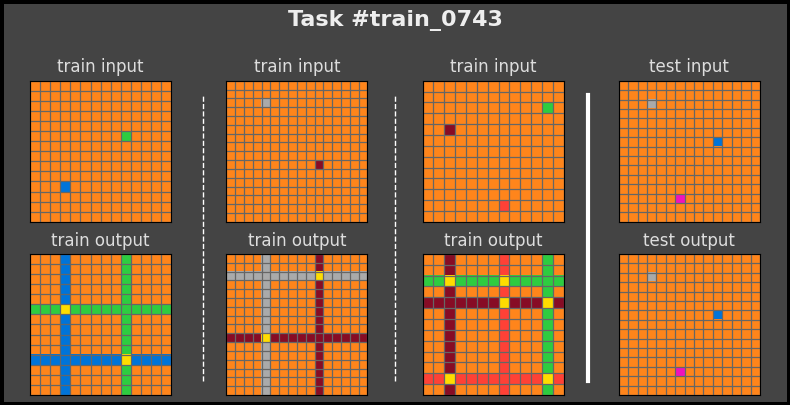

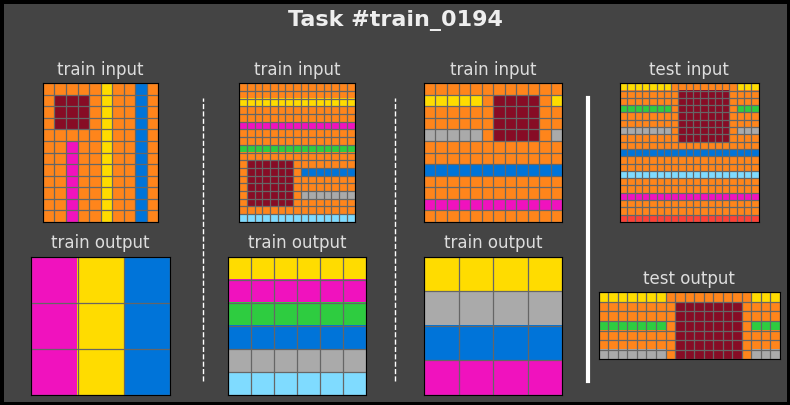

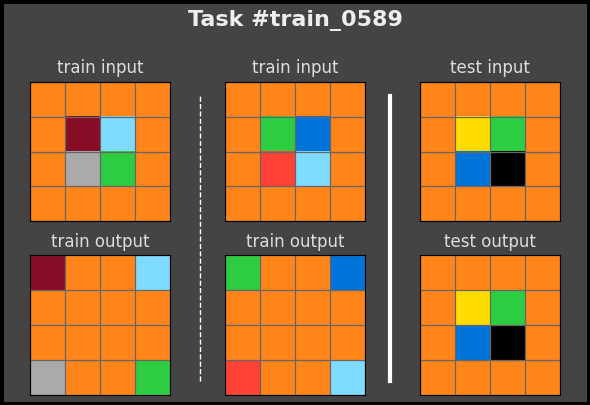

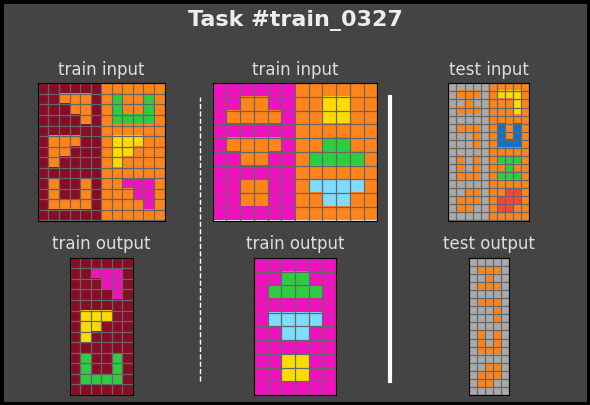

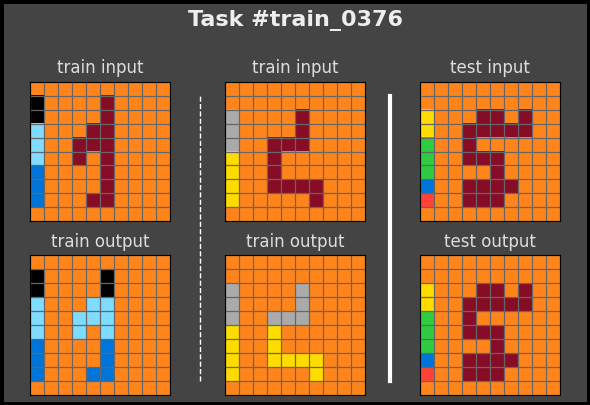

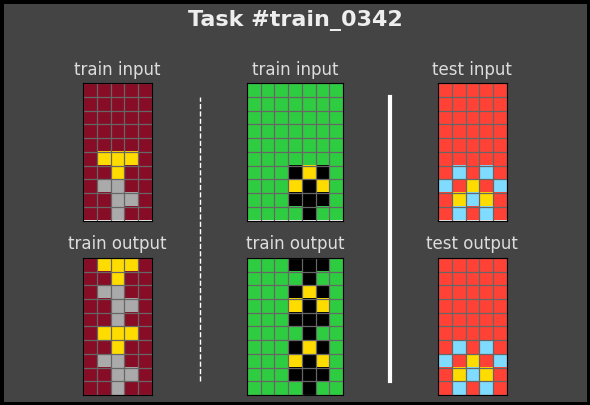

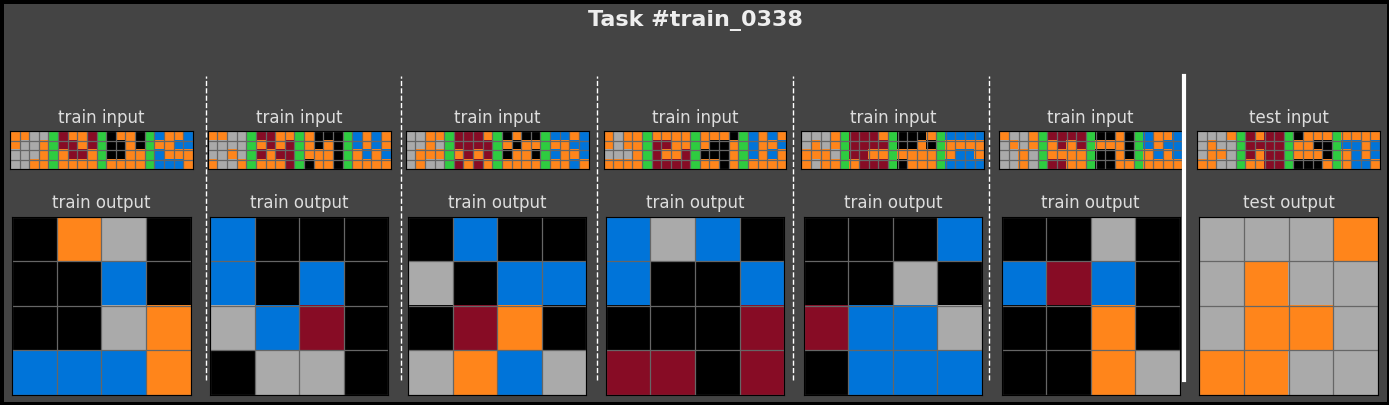

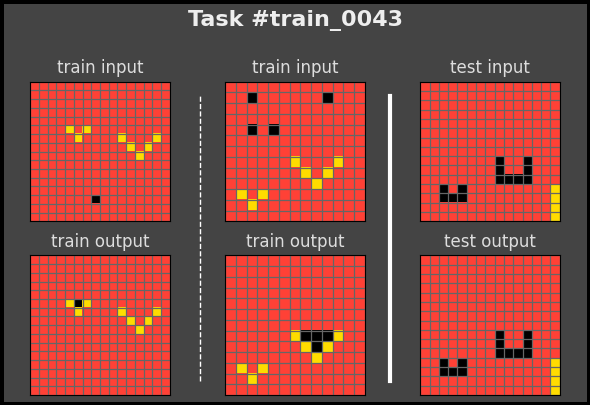

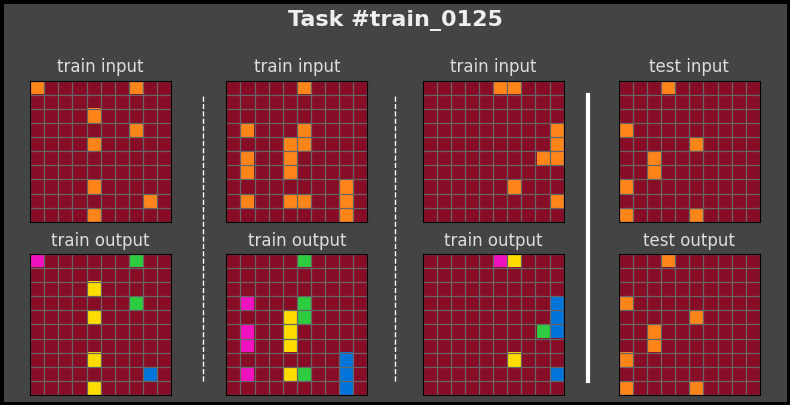

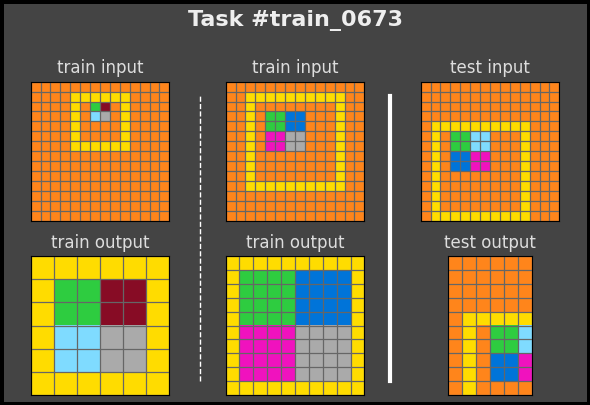

In [11]:
for solution in train_preds:
    task_id = list(solution.keys())[0]
    task = train_data[task_id]
    visualize_task(
        task_data=task,
        task_id=task_id, 
        size=2.0, 
        w1=.9,
        task_solutions=solution
    )

# Predict on Test Set

In [12]:
# Load sample submission to see the format
ss = pd.read_csv(
    osp.join(Config.data_path, 'SampleSubmission.csv'),
    dtype={"row": str}
)

print(f"✓ Sample submission has {len(ss)} predictions")

✓ Sample submission has 2303 predictions


In [13]:
test_out_rows = get_row_sizes(ss)
test_out_rows

,ID_,n_rows
0,test_0000,10
1,test_0001,12
2,test_0002,10
3,test_0003,8
4,test_0004,30
...,...,...
180,test_0180,25
181,test_0181,10
182,test_0182,19
183,test_0183,10


In [14]:
test_out_rows.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_rows,185.0,12.448649,7.509328,1.0,8.0,10.0,16.0,30.0


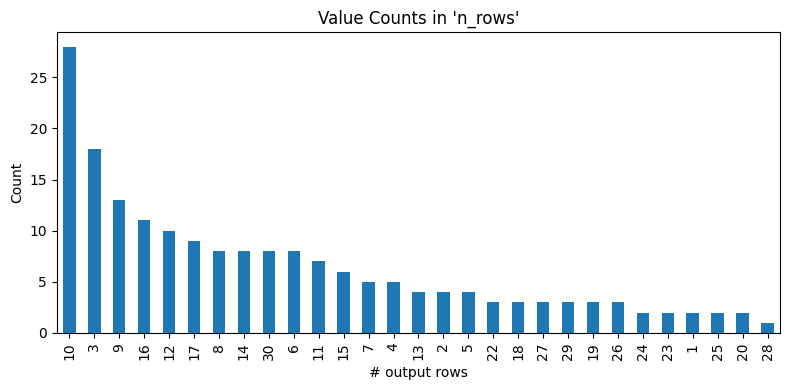

In [15]:
value_counts = test_out_rows["n_rows"].value_counts()

value_counts.plot(kind="bar", figsize=(8, 4))
plt.xlabel("# output rows")
plt.ylabel("Count")
plt.title("Value Counts in 'n_rows'")
plt.tight_layout()
plt.show()

In [16]:
task_id = "test_0003"
n_out_rows = test_out_rows.loc[test_out_rows["ID_"] == task_id, "n_rows"].item()
task = test_data[task_id]
train = task["train"]
test = task["test"][0]

inferred_out_shape = infer_out_shape(
    train_pairs=train, 
    test_input=test["input"],  
    expected_rows=n_out_rows,
    verbose=False
)

pred = model.solve(
    task=task, 
    expected_rows=inferred_out_shape[0],
    verbose=True
) 

[INFO] Input and output shapes are identical in all pairs
[INFO] Fallback - Copy input solver...
[INFO] Adjusting grid...
[INFO] expected_shape=(8, 12)
[INFO] final_shape=(8, 12)
[INFO] Done!


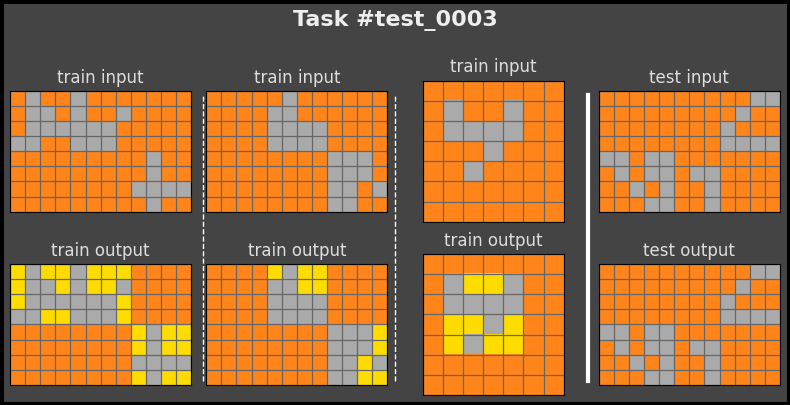

In [17]:
solution = {
    f"{task_id}": pred
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

# Submission

In [18]:
test_out_rows_sorted = test_out_rows.sort_values(by="n_rows", ascending=False)
test_out_rows_sorted

,ID_,n_rows
4,test_0004,30
22,test_0022,30
83,test_0083,30
74,test_0074,30
161,test_0161,30
...,...,...
54,test_0054,2
143,test_0143,2
108,test_0108,2
135,test_0135,1


In [19]:
%%time

test_preds = []

for idx, row in tqdm(test_out_rows_sorted.iterrows(), total=len(test_out_rows_sorted)):
    
    task = test_data[row.ID_]
    train = task["train"]
    test = task["test"][0]

    pred = model.solve(
        task=task, 
        expected_rows=row.n_rows,
        verbose=False
    )  

    test_preds.append(pred)


  0%|          | 0/185 [00:00<?, ?it/s]

CPU times: user 11.1 ms, sys: 2.12 ms, total: 13.3 ms
Wall time: 11.5 ms


In [20]:
date_str = datetime.now().strftime("%Y-%m-%d_%H-%M")
sub_filename = f"{date_str}-submission-{Config.model_name}-{Config.experiment}.csv"
out_path = osp.join(Config.submission_path, sub_filename)

generate_submission(
    predictions=test_preds, 
    test_data=test_data, 
    expected_rows_list=test_out_rows_sorted, 
    output_path=out_path
)

[INFO] Submission saved to ./submissions/2025-08-02_16-03-submission-arc-solver-Qwen2.5-14B-Instruct-llm-fs.csv


In [21]:
submision = pd.read_csv(out_path)
submision

,ID,row
0,test_0000_1,7777777777
1,test_0000_2,7557775557
2,test_0000_3,7757777757
3,test_0000_4,7577777577
4,test_0000_5,7555775555
...,...,...
2298,test_0184_6,7787533335333777777
2299,test_0184_7,7787537775783777777
2300,test_0184_8,7787537775783777777
2301,test_0184_9,7787555555783777777


In [22]:
submision.shape == ss.shape, sum(submision.ID == ss.ID)/ss.shape[0]

(True, 1.0)

In [23]:
predictions = reconstruct_grids(submision)

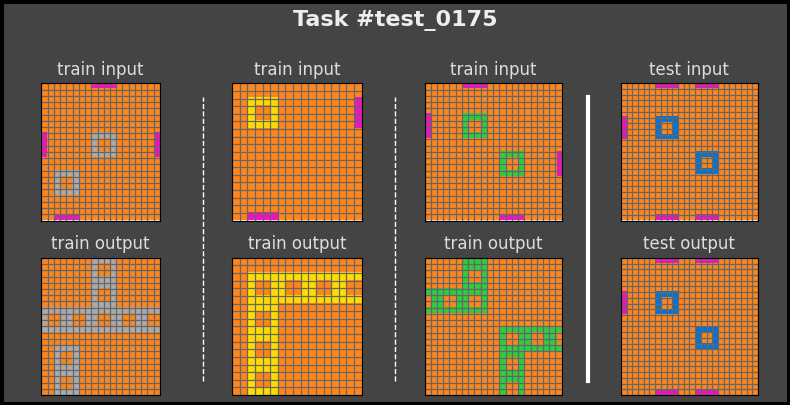

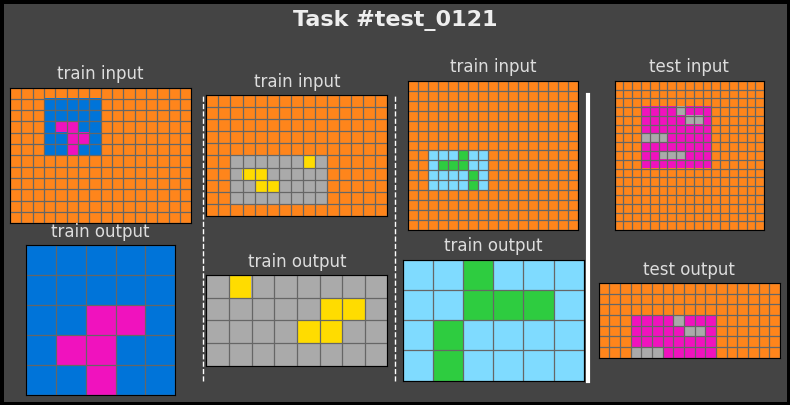

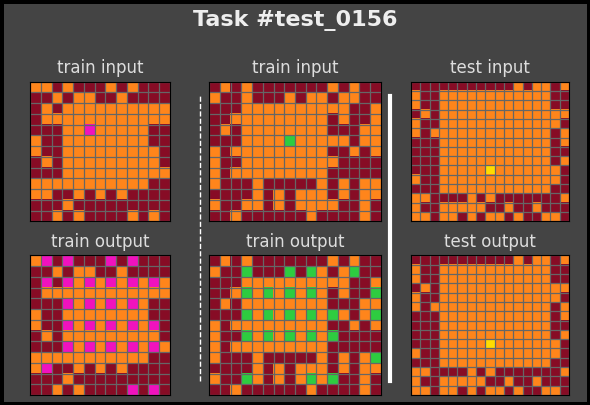

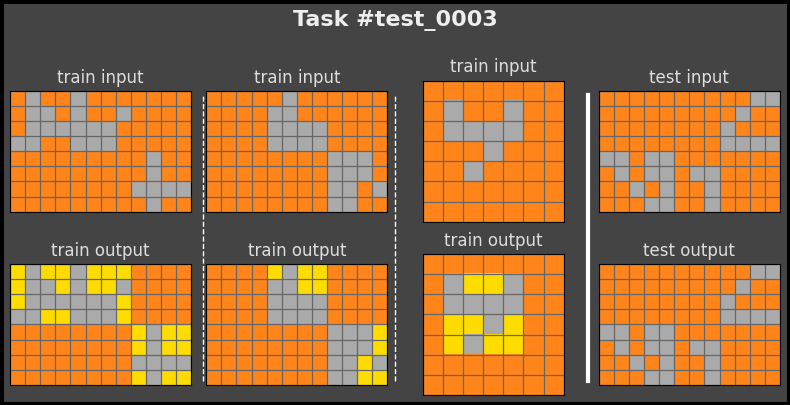

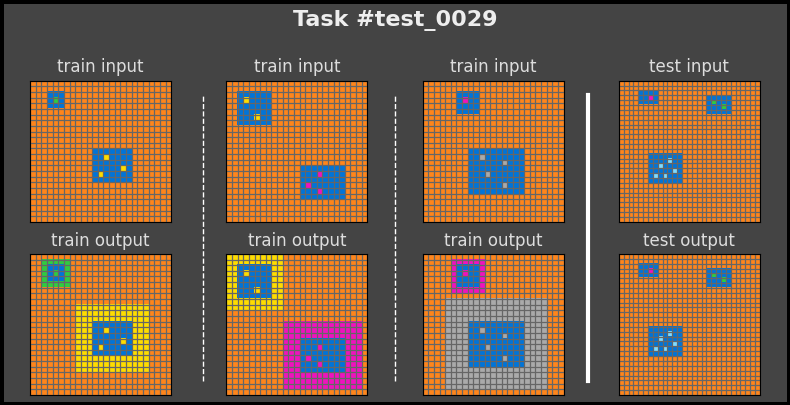

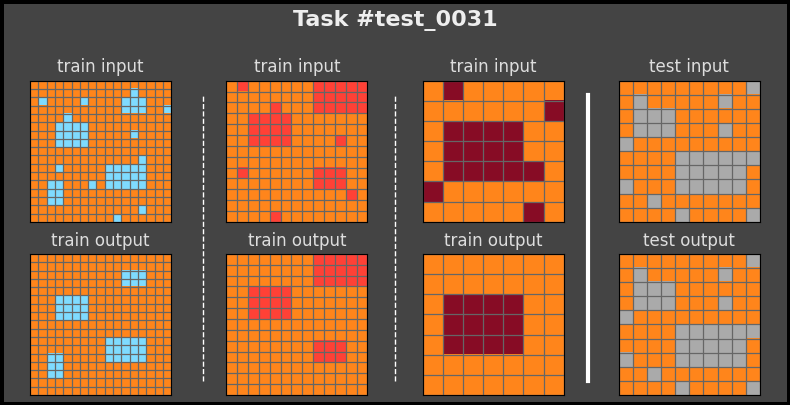

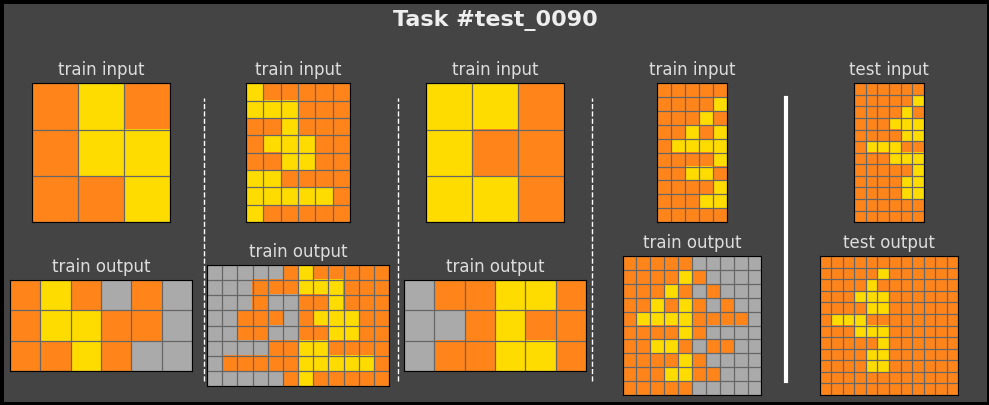

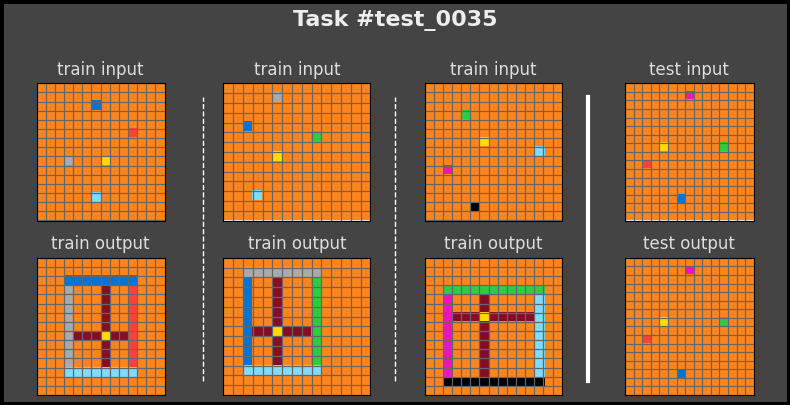

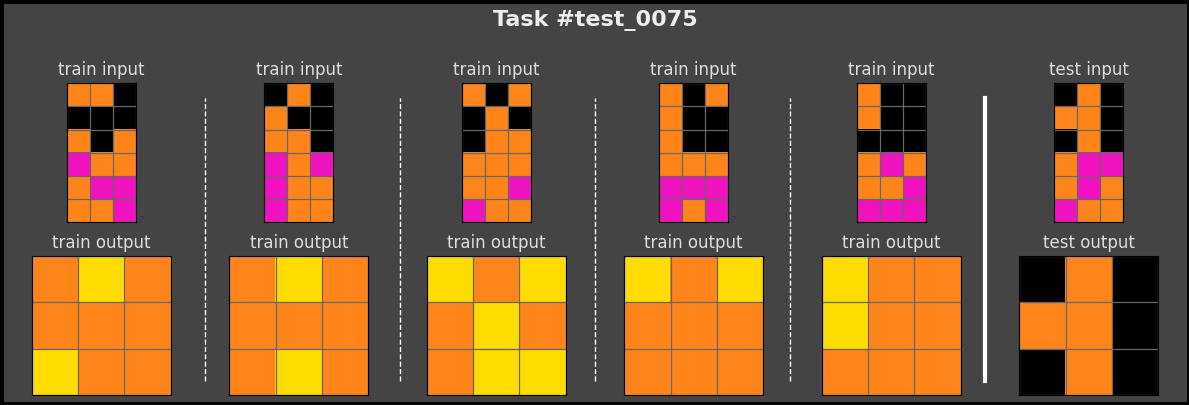

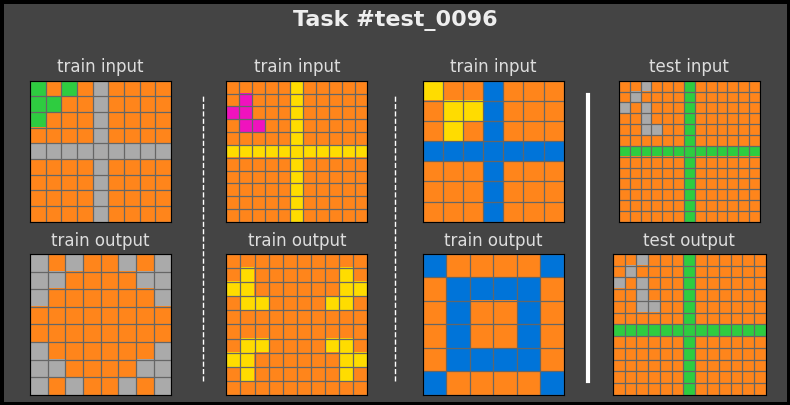

In [24]:
for i in range(10):
    task_id, task_data = sample_arc_task(test_data, split=None)    
    visualize_task(task_data=task_data,task_id=task_id, size=2.0, w1=.9, task_solutions=predictions)